In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import os
import logging
import torch
import socket
import pickle
import tqdm
import random
import numpy as np

from deepprojection.datasets.lite    import SPIDataset, SPIOnlineDataset
from deepprojection.model            import OnlineTripletSiameseModel, ConfigSiameseModel
from deepprojection.validator        import MultiwayQueryValidator, ConfigValidator
from deepprojection.encoders.convnet import FewShotModel, ConfigEncoder, Hirotaka0122
from deepprojection.utils            import EpochManager, MetaLog, init_logger, split_dataset, ConfusionMatrix, set_seed

from image_preprocess_faulty_sq_for_validate import DatasetPreprocess

# [[[ SEED ]]]
seed = 0
set_seed(seed)


# [[[ CONFIG ]]]
# Set the timestamp and epoch to load the corresponding model
# timestamp = "2022_1219_1129_04"
# epoch = 92

timestamp = "2022_1219_2333_41"
epoch = 119

# timestamp = "2022_1219_2353_04"
# epoch = 37

# Define the pdb...
# pdb = '6OR5'
pdb = '6EMW'
pdb = '1TZN'

# Define the chkpt file...
fl_chkpt = f"{timestamp}.epoch={epoch}.chkpt"

# Define the test set
size_sample_query = 1000
num_max_support   = 10
frac_support      = 0.4
size_batch        = 100
trans             = None
alpha             = 0.02

# Initialize a log file...
init_logger(log_name = 'validate.query.test', timestamp = timestamp, returns_timestamp = False, saves_log = False)


# [[[ DATASET ]]]
# Set up parameters for an experiment...
drc_dataset  = 'fastdata.h5/'
fl_dataset   = f'{pdb}.relabel.pickle'
path_dataset = os.path.join(drc_dataset, fl_dataset)

# Load raw data...
with open(path_dataset, 'rb') as fh:
    dataset_list = pickle.load(fh)

# Split data into two -- support set and query set...
data_support, data_query = split_dataset(dataset_list, frac_support, seed = None)

# Fetch all hit labels...
hit_list = list(set( [ hit for _, (pdb, hit), _ in data_support ] ))

# Form support set...
support_hit_to_idx_dict = { hit : [] for hit in hit_list }
for enum_data, (img, label, metadata) in enumerate(data_support):
    _, hit = label
    support_hit_to_idx_dict[hit].append(enum_data)

for hit, idx_in_data_support in support_hit_to_idx_dict.items():
    if len(support_hit_to_idx_dict[hit]) > num_max_support:
        support_hit_to_idx_dict[hit] = random.sample(support_hit_to_idx_dict[hit], k = num_max_support)

# Form query dataset...
dataset_query = SPIOnlineDataset( dataset_list   = data_query, 
                                  size_sample    = size_sample_query,
                                  joins_metadata = False,
                                  trans          = trans, )

# Preprocess dataset...
# Data preprocessing can be lengthy and defined in dataset_preprocess.py
img_orig            = dataset_query[0][0][0]   # idx, fetch img
dataset_preproc     = DatasetPreprocess(img_orig)
trans               = dataset_preproc.config_trans()
dataset_query.trans = trans
img_trans           = dataset_query[0][0][0]


# [[[ IMAGE ENCODER ]]]
# Config the encoder...
dim_emb        = 128
size_y, size_x = img_trans.shape[-2:]
config_encoder = ConfigEncoder( dim_emb = dim_emb,
                                size_y  = size_y,
                                size_x  = size_x,
                                isbias  = True )
encoder = FewShotModel(config_encoder)
# encoder = Hirotaka0122(config_encoder)

# [[[ DEVICE ]]]
device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'

# [[[ MODEL ]]]
# Config the model...
config_siamese = ConfigSiameseModel( alpha = alpha, encoder = encoder, )
model = OnlineTripletSiameseModel(config_siamese)
model.init_params(fl_chkpt = fl_chkpt)
model.to(device = device)

# [[[ EMBEDDING (SUPPORT) ]]]
support_batch_emb_dict = { hit : None for hit in hit_list }
for hit in hit_list:
    support_idx_list    = support_hit_to_idx_dict[hit]
    num_example_support = len(support_idx_list)
    for enum_support_idx, support_idx in enumerate(support_idx_list):
        # Fetch data from support...
        img = data_support[support_idx][0]
        img = trans(img)
        img = img[None,]

        # Preallocate tensor...
        if enum_support_idx == 0:
            size_c, size_y, size_x = img.shape
            batch_img = torch.zeros((num_example_support, size_c, size_y, size_x))

        # Save image as tensor...
        batch_img[enum_support_idx] = torch.tensor(img)

    with torch.no_grad():
        batch_img = batch_img.to(device = device)
        support_batch_emb_dict[hit] = model.encoder.encode(batch_img)


# [[[ EMBEDDING (QUERY) ]]]
num_test       = len(dataset_query)
query_idx_list = range(num_test)
for enum_query_idx, i in enumerate(query_idx_list):
    # Fetch data from query
    img = dataset_query[i][0]

    # Preallocate tensor...
    if enum_query_idx == 0:
        size_c, size_y, size_x = img.shape
        batch_img = torch.zeros((num_test, size_c, size_y, size_x))

    # Save image as tensor...
    batch_img[enum_query_idx] = torch.tensor(img)

with torch.no_grad():
    batch_img = batch_img.to(device = device)
    query_batch_emb = model.encoder.encode(batch_img)


# [[[ METRIC ]]]
diff_query_support_hit_to_idx_dict = {}
for hit in hit_list:
    diff_query_support_hit_to_idx_dict[hit] = query_batch_emb[:,None] - support_batch_emb_dict[hit]

dist_dict = {}
for hit in hit_list:
    dist_dict[hit] = torch.sum(diff_query_support_hit_to_idx_dict[hit] * diff_query_support_hit_to_idx_dict[hit], dim = -1)

12/20/2022 10:14:58 INFO image_preprocess_faulty_sq_for_validate - ___/ Preprocess Settings \___
12/20/2022 10:14:58 INFO image_preprocess_faulty_sq_for_validate - Apply Poisson noise. 
12/20/2022 10:14:58 INFO image_preprocess_faulty_sq_for_validate - Apply Gaussian noise. sigma = 0.15.
12/20/2022 10:14:58 INFO image_preprocess_faulty_sq_for_validate - TRANS : Apply cropping.
12/20/2022 10:14:58 INFO image_preprocess_faulty_sq_for_validate - TRANS : Apply random rotation. angle = None, center = (48, 48).
12/20/2022 10:14:58 INFO deepprojection.encoders.convnet     - ___/ Configure Encoder \___
12/20/2022 10:14:58 INFO deepprojection.encoders.convnet     - KV - dim_emb          : 128
12/20/2022 10:14:58 INFO deepprojection.encoders.convnet     - KV - size_y           : 96
12/20/2022 10:14:58 INFO deepprojection.encoders.convnet     - KV - size_x           : 96
12/20/2022 10:14:58 INFO deepprojection.encoders.convnet     - KV - isbias           : True
12/20/2022 10:14:58 INFO deepprojec

In [2]:
enum_to_hit_dict = {}
for enum_hit, hit in enumerate(hit_list):
    enum_to_hit_dict[enum_hit] = hit
    
    # Fetch the values and indices the support with the min dist when measured against the query...
    min_support_val, min_support_idx = dist_dict[hit].min(dim = -1)
    if enum_hit == 0:
        min_support_tensor = torch.zeros((len(hit_list), *min_support_val.shape))
        
    min_support_tensor[enum_hit] = min_support_val

In [3]:
pred_hit_as_enum_list = min_support_tensor.min(dim = 0)[1]

In [4]:
pred_hit_list = [ enum_to_hit_dict[enum.item()] for enum in pred_hit_as_enum_list ]

In [5]:
real_hit_list = [ dataset_query[idx][1][1] for idx in query_idx_list ]

In [6]:
# New container to store validation result (thus res_dict) for each label...
res_dict = {}
for hit in hit_list: res_dict[hit] = { i : [] for i in hit_list }

In [7]:
for pred_hit, real_hit in zip(pred_hit_list, real_hit_list):
    res_dict[pred_hit][real_hit].append( None )

In [8]:
# Get macro metrics...
confusion_matrix = ConfusionMatrix(res_dict)

# Formating purpose...
disp_dict = {
              1 : "single-hit",
              2 : " multi-hit",
            }

# Report multiway classification...
msgs = []
for pred_hit in sorted(hit_list):
    disp_text = disp_dict[pred_hit]
    msg = f"{disp_text}  |"
    for real_hit in sorted(hit_list):
        num = len(res_dict[pred_hit][real_hit])
        msg += f"{num:>12d}"

    metrics = confusion_matrix.get_metrics(pred_hit)
    for metric in metrics:
        msg += f"{metric:>12.2f}"
    msgs.append(msg)

msg_header = " " * (msgs[0].find("|") + 1)
for label in sorted(hit_list): 
    disp_text = disp_dict[label]
    msg_header += f"{disp_text:>12s}"

for header in [ "accuracy", "precision", "recall", "specificity", "f1" ]:
    msg_header += f"{header:>12s}"
print(msg_header)

msg_headerbar = "-" * len(msgs[0])
print(msg_headerbar)
for msg in msgs:
    print(msg)

               single-hit   multi-hit    accuracy   precision      recall specificity          f1
-------------------------------------------------------------------------------------------------
single-hit  |         285           9        0.77        0.97        0.57        0.98        0.72
 multi-hit  |         218         488        0.77        0.69        0.98        0.57        0.81


In [9]:
confusion_matrix.get_metrics(1)[0]

0.773

### Visualize query and support

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
num_test = len(dataset_query)
query_idx_list = range(num_test)

min_val_idx_dict = {}
for hit in (1, 2):
    min_val_idx_dict[hit] = dist_dict[hit].min(dim = -1)
    
global_query_support_list = []
msg_list = []
for idx_enum, idx_query in enumerate(query_idx_list):
    query_support_list = [idx_query]
    val_support_list = []
    for hit in (1, 2):
        idx_best_support = min_val_idx_dict[hit][1][idx_query]
        idx_best_support = support_hit_to_idx_dict[hit][idx_best_support.item()]
        query_support_list.append(idx_best_support)
        
        val_best_support = min_val_idx_dict[hit][0][idx_query]
        val_support_list.append(val_best_support)
    global_query_support_list.append(query_support_list)
    
    metadata_query = dataset_query[idx_query][2]
    metadata_support = ' '.join([ data_support[query_support_list[hit]][2] for hit in (1, 2) ])    # Spaghetti code, hit happens to be 1 and 2
    label_pred = '1' if val_support_list[0] < val_support_list[1] else '2'
    msg_list.append(f"{metadata_query}, {metadata_support}, label = {label_pred}")

In [28]:
dataset_query.trans = trans
dataset_query.trans = None

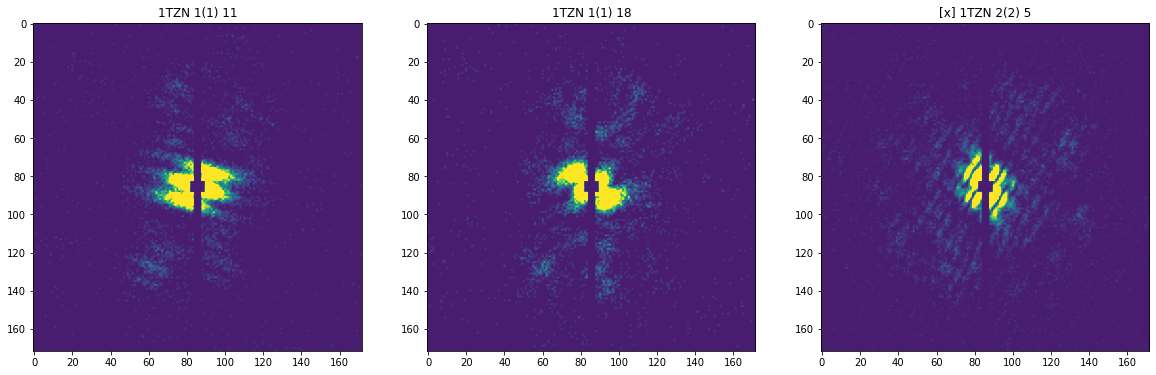

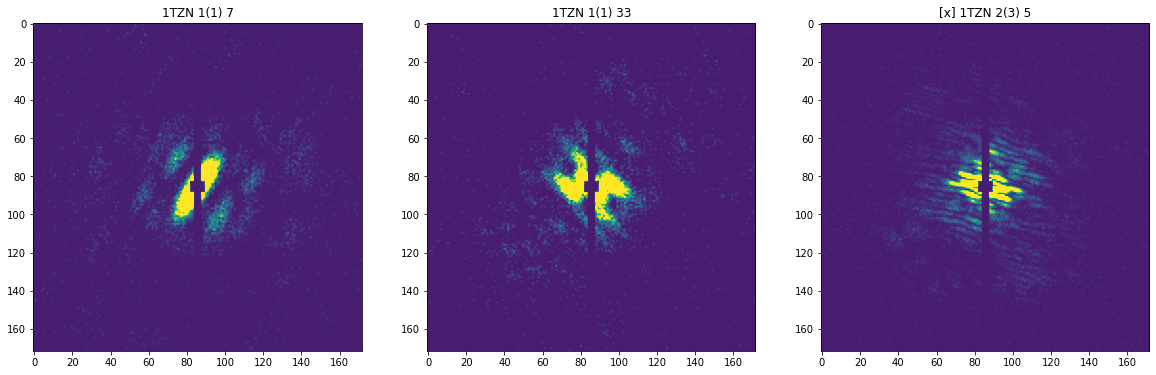

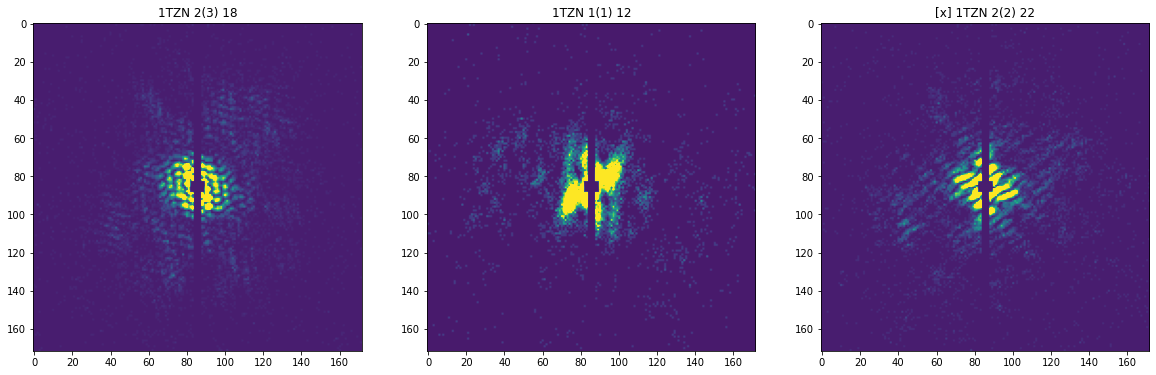

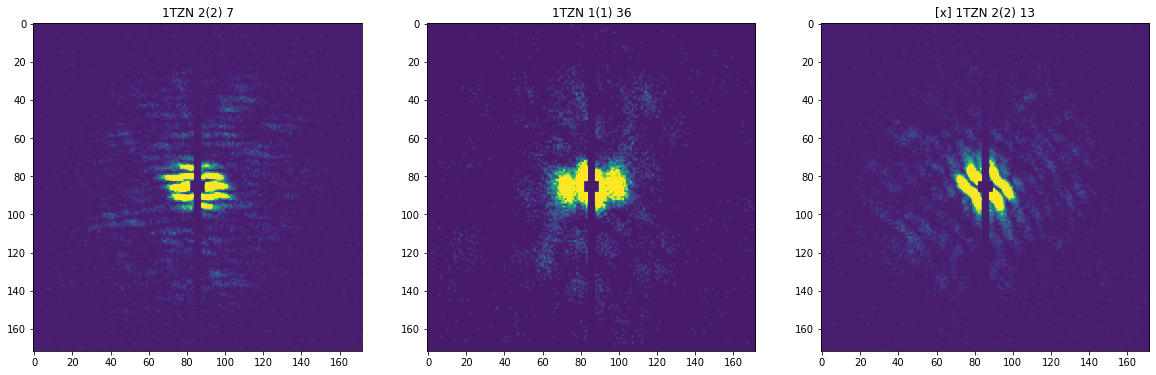

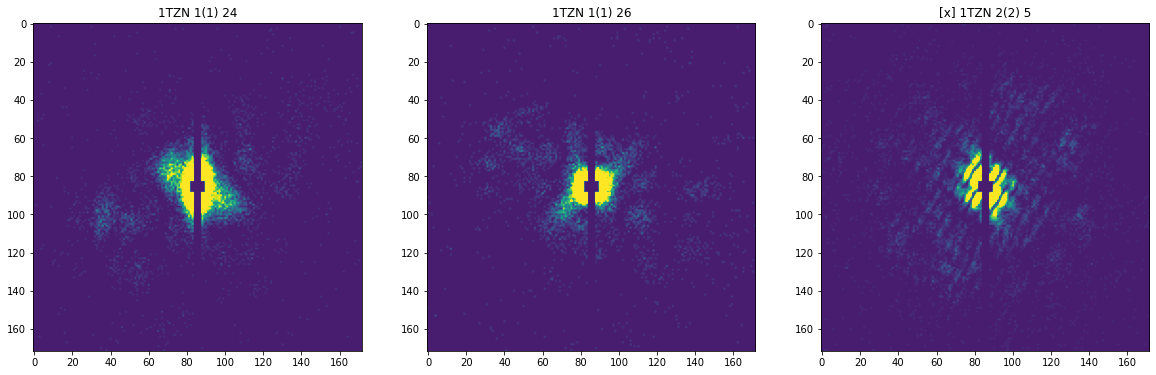

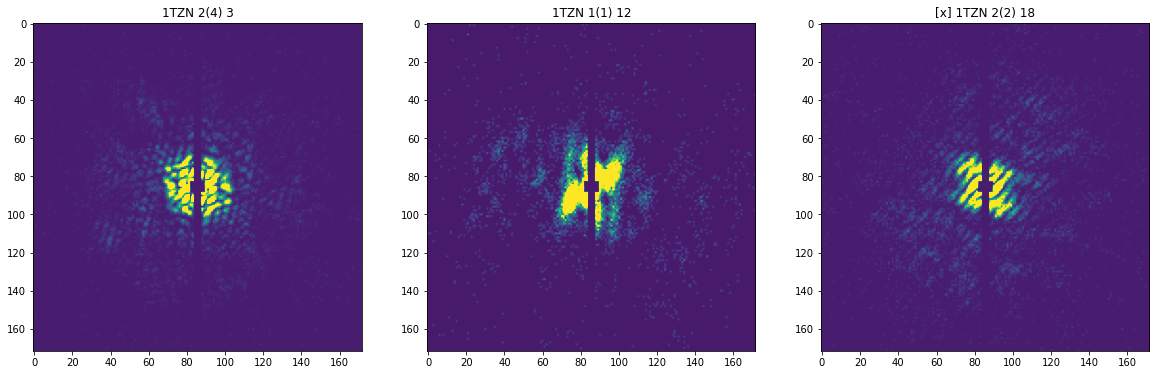

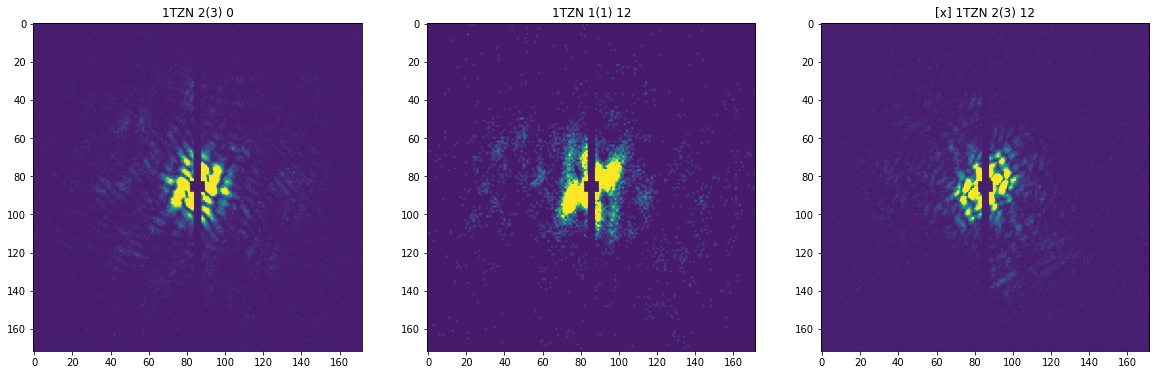

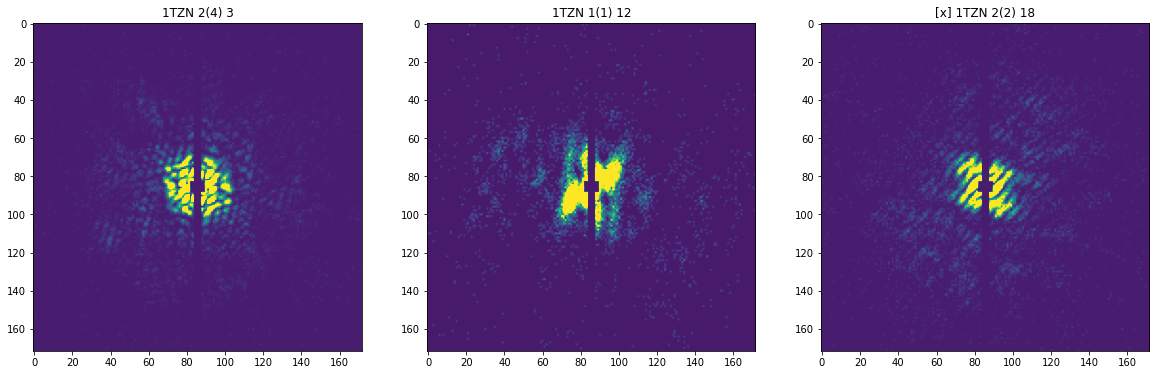

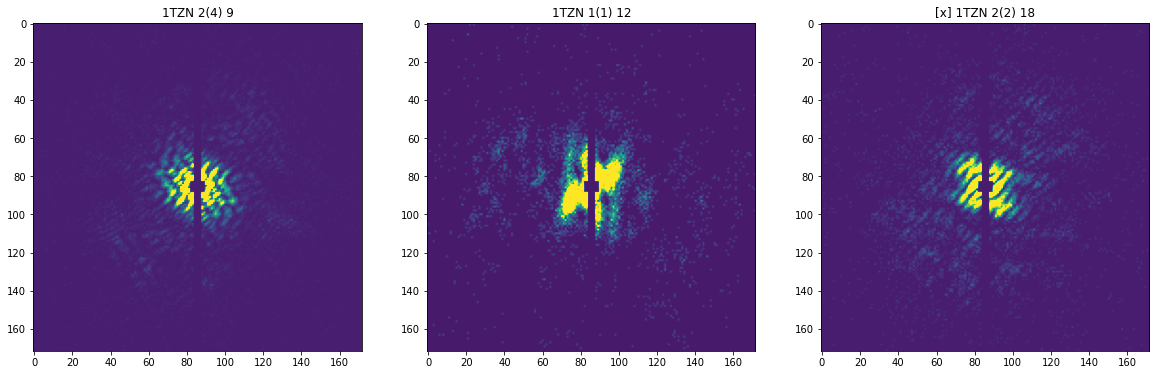

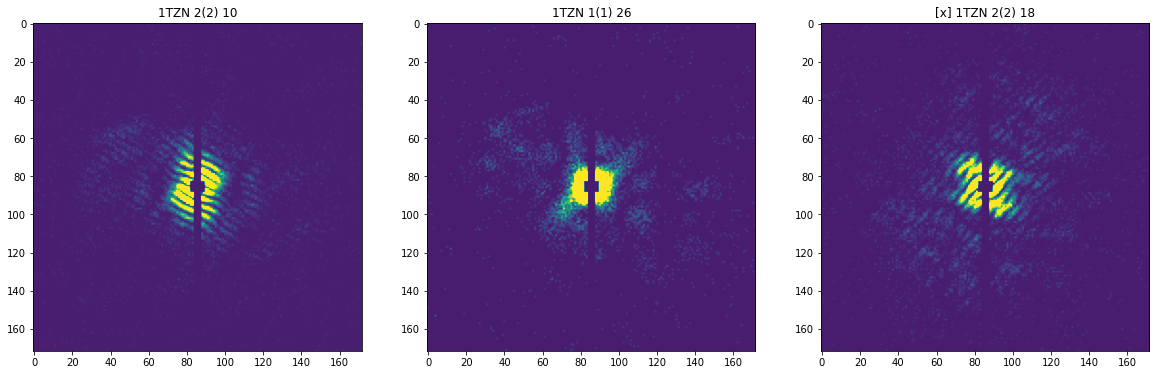

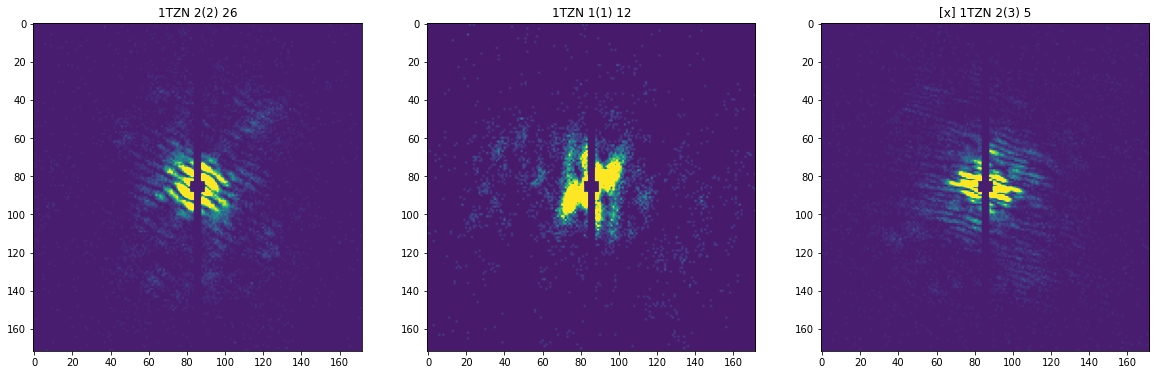

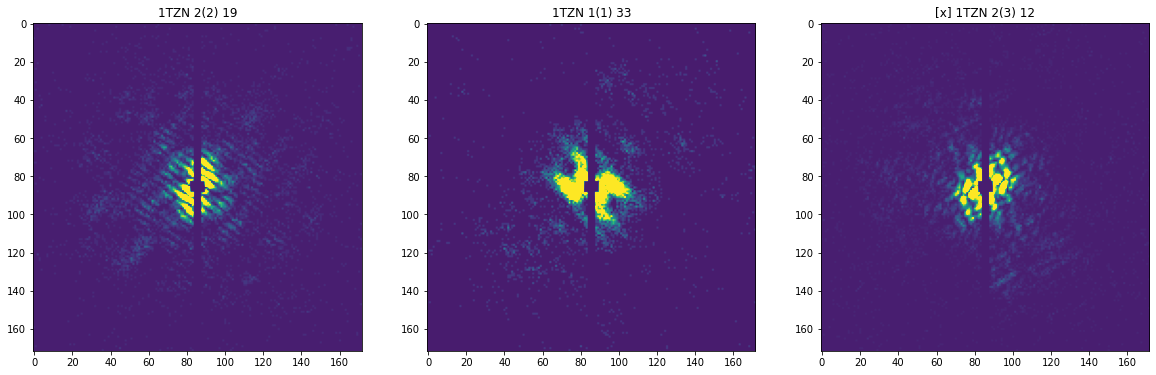

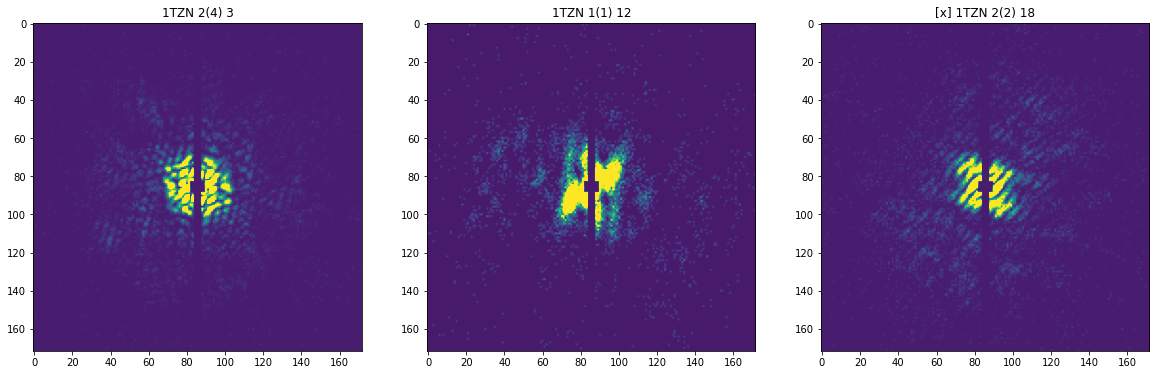

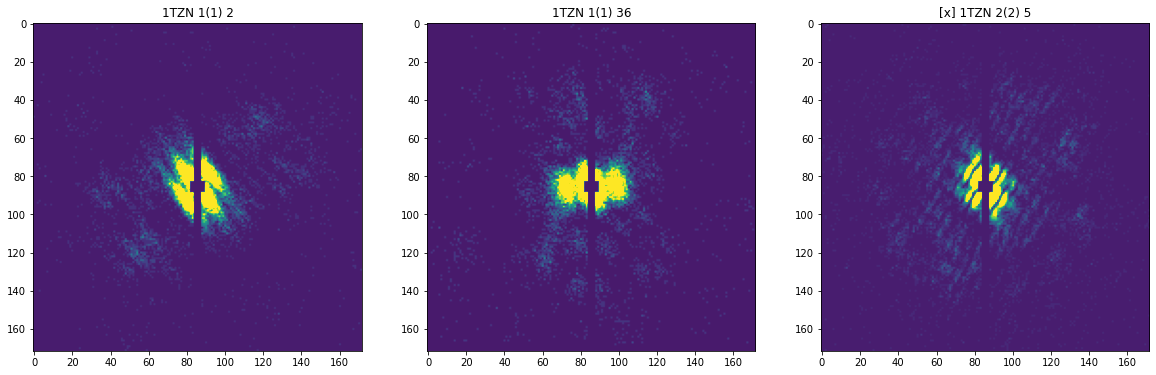

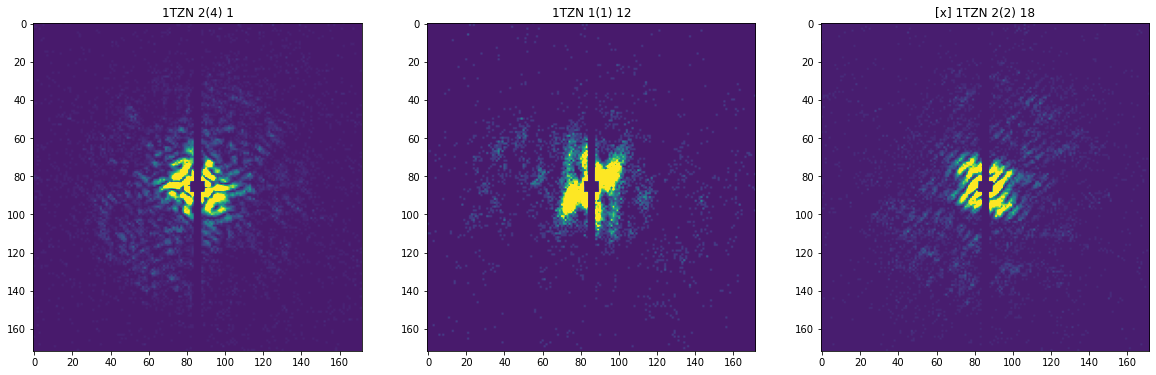

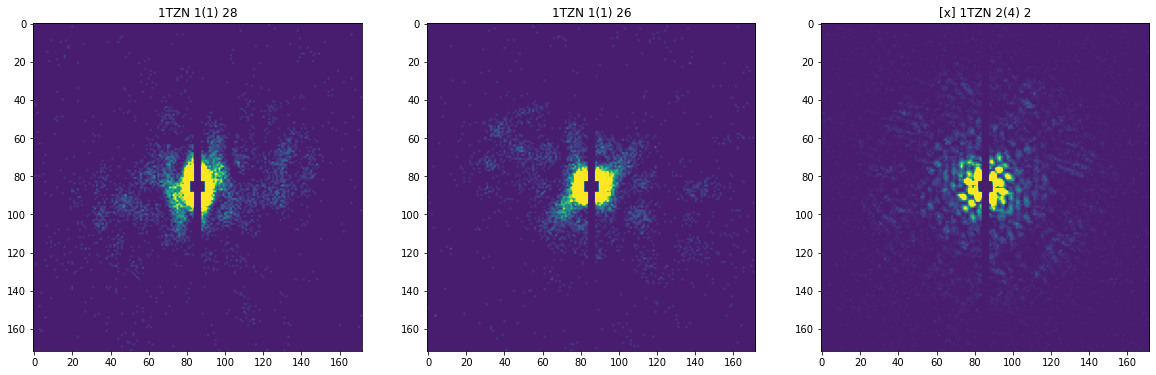

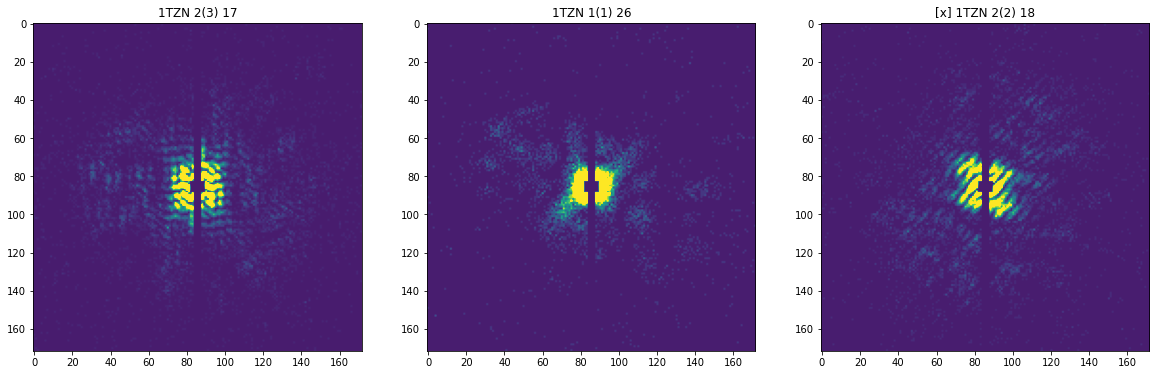

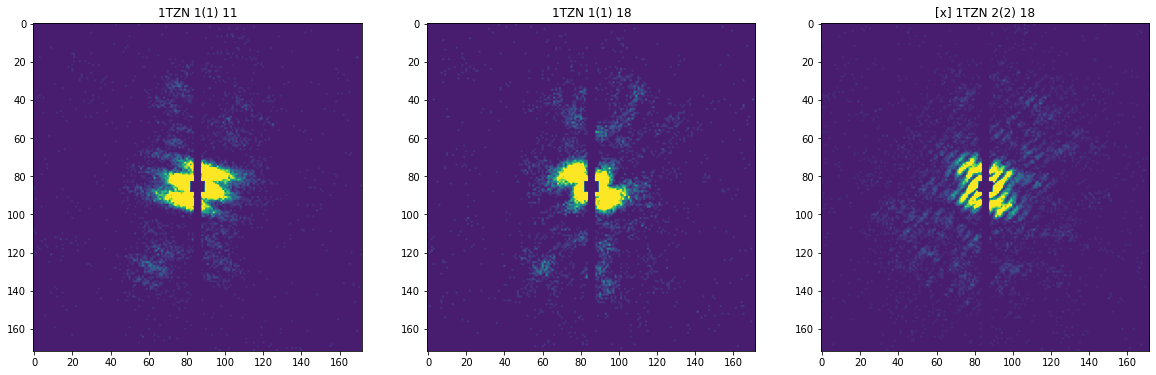

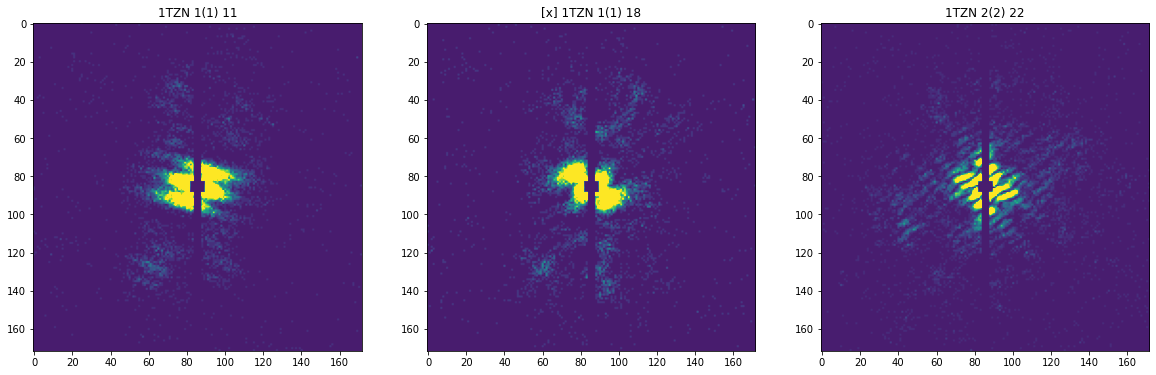

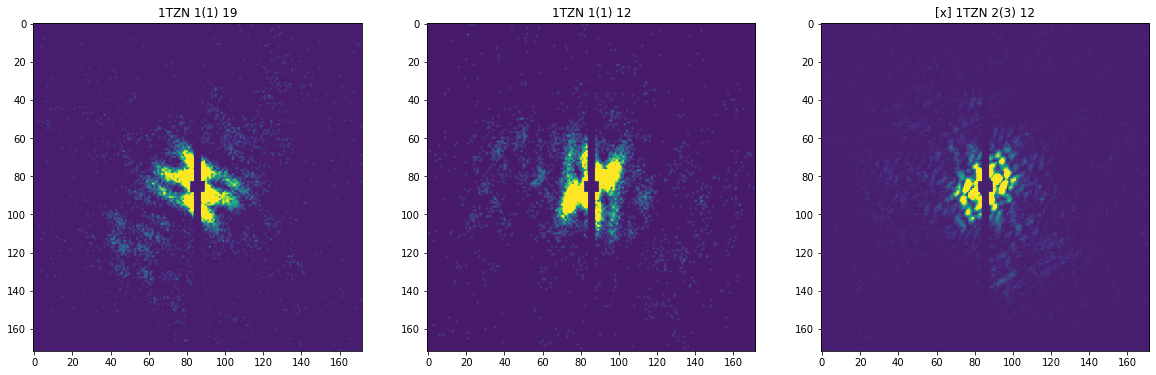

In [29]:
for idx_query in range(20):
    label_pred = int(msg_list[idx_query][-1])    # [WORKAROUND]

    q, s1, s2 = global_query_support_list[idx_query]

    nrows, ncols = 1, 3
    fig = plt.figure(figsize = (20, 8))

    gspec   = fig.add_gridspec(nrows, ncols)
    ax_img  = [ fig.add_subplot(gspec[0,i]) for i in range(ncols) ]

    ax = ax_img[0]
    img, label, metadata = dataset_query[q]
    # plt.figure(figsize = (10, 8))
    img = img[0]
    vmin = img.mean() - 0.5 * img.std()
    vmax = img.mean() + 4.0* img.std()
    ax.imshow(img, vmin = vmin, vmax = vmax)
    ax.set_title(metadata)

    for enum_i, s in enumerate((s1, s2)):
        ax_i = enum_i + 1
        ax   = ax_img[ax_i]
        img, label, metadata = data_support[s]
        if int(label[1]) == label_pred: metadata = "[x] " + metadata
        
        if dataset_query.trans is not None: img = dataset_query.trans(img)
        # plt.figure(figsize = (10, 8))
        vmin = img.mean() - 0.5 * img.std()
        vmax = img.mean() + 4.0* img.std()
        ax.imshow(img, vmin = vmin, vmax = vmax)
        ax.set_title(metadata)